In [1]:
import numpy as np
import os

In [2]:
os.chdir('D:/travel_images')

In [3]:
data_dir=os.getcwd()

In [4]:
import glob

In [5]:
architecture_list=glob.glob('architecture*.*')
art_and_culture_list=glob.glob('art_and_culture*.*')
food_and_drinks_list=glob.glob('food_and_drinks*.*')
travel_and_adventure_list=glob.glob('travel_and_adventure*.*')

In [6]:
len(architecture_list),len(art_and_culture_list), len(food_and_drinks_list), len(travel_and_adventure_list)

(8763, 8695, 8774, 1151)

In [7]:
print(len(architecture_list)+len(art_and_culture_list)+len(food_and_drinks_list)+len(travel_and_adventure_list))

27383


In [8]:
data_list=architecture_list[:1000]+art_and_culture_list[:1000]+food_and_drinks_list[:1000]+travel_and_adventure_list[:1000]

In [9]:
len(data_list)

4000

In [11]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [12]:
label=[]
for x in data_list:
    label.append(text_to_word_sequence(x, filters='()')[0])

In [13]:
# 라벨 인코더 - 카테고리형 문자를 숫자로 자동 변환해주는 역할
from sklearn.preprocessing import LabelEncoder

In [14]:
encoder=LabelEncoder()
label_encode=encoder.fit_transform(label)

In [15]:
encoder.classes_ # 인코딩된 분류 이름들

array(['architecture', 'art_and_culture', 'food_and_drinks',
       'travel_and_adventure'], dtype='<U20')

In [17]:
import cv2
import matplotlib.pyplot as plt

In [18]:
# 크기를 동일하게 맞추어 변경해주자
data_height=150
data_width=150
channel_n=3 # 컬러 색상으로 설정

In [19]:
# 읽어온 이미지 목록을 넣으면 라벨링, 스케일링, 리사이징하는 함수 선언
def make_file(data_height, data_width, channel_n, data_list_len): # 높이, 너비, 컬러, 리스트 길이
    # 라벨링한 결과를 넣을 1차원 리스트
    label=[]
    # 4차원으로 만들기 위한 4차원 리스트 필요
    images=np.zeros((data_list_len, data_height, data_width, channel_n))
    # 이미지 리스트에서 하나씩 꺼내서 라벨링, 스케일링, 리사이징
    for i, image in enumerate(data_list):
        # 라벨링 : dog.01.jpg
        tokens=text_to_word_sequence(image, filters='()')
        label.append(tokens[0])
        
        # 읽어서 스케일링, 리사이징 
        image=cv2.imread(image) /255 #읽기, 스케일링
        image=cv2.resize(image, (data_height, data_width)) #리사이징
        # 4차원 리스트에 하나씩 append
        images[i, :, :, :]=image
    label2=np.array(label)
    return label2, images

In [20]:
labels, images=make_file(data_height, data_width, channel_n, len(data_list))

In [21]:
labels

array(['architecture', 'architecture', 'architecture', ...,
       'travel_and_adventure', 'travel_and_adventure',
       'travel_and_adventure'], dtype='<U20')

In [22]:
labels.shape

(4000,)

In [23]:
images.shape

(4000, 150, 150, 3)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(images, label_encode, test_size= 0.2, random_state=55)

In [26]:
print(X_train.shape, X_test.shape)

(3200, 150, 150, 3) (800, 150, 150, 3)


In [27]:
y_train

array([1, 0, 2, ..., 0, 0, 0], dtype=int64)

In [28]:
# 딥러닝 모델 만들기
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
model=Sequential()
# 특성 추출 레이어를 쌓아준다.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(data_height, data_width, 3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2,2)))

# 딥러닝 학습 레이어를 쌓아준다.
# 입력 -- 은닉 -- 출력 순서대로 쌓아준다.

# 입력층(1개) => 1차원이어야함
model.add(Flatten()) # 이미지 데이터를 1차원으로 만들어주는 객체

# 은닉층
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5)) 
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.5))

# 출력층(1개) => 딥러닝하는 학습의 종류에 따라 다르게 써주어야 함
# 이진 분류인 경우(1, sigmoid)
# 다중 분류인 경우(n, softmax)
# 회귀인 경우(1, linear)
model.add(Dense(4, activation='softmax')) #결과가 엘리먼트로 출력됨. 0.5를 기준으로 판별

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
es=EarlyStopping(patience=3, restore_best_weights=True)
cp=ModelCheckpoint('best_travel_cnn.h5')
cnn_history=model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test),
                      callbacks=[es, cp], verbose=2)

Epoch 1/50
25/25 - 30s - loss: 1.3180 - accuracy: 0.3537 - val_loss: 1.2371 - val_accuracy: 0.4575 - 30s/epoch - 1s/step
Epoch 2/50
25/25 - 29s - loss: 1.3109 - accuracy: 0.3559 - val_loss: 1.2862 - val_accuracy: 0.4350 - 29s/epoch - 1s/step
Epoch 3/50
25/25 - 29s - loss: 1.2738 - accuracy: 0.3891 - val_loss: 1.1768 - val_accuracy: 0.4875 - 29s/epoch - 1s/step
Epoch 4/50
25/25 - 29s - loss: 1.2504 - accuracy: 0.4016 - val_loss: 1.1651 - val_accuracy: 0.4688 - 29s/epoch - 1s/step
Epoch 5/50
25/25 - 28s - loss: 1.2395 - accuracy: 0.4178 - val_loss: 1.1307 - val_accuracy: 0.4963 - 28s/epoch - 1s/step
Epoch 6/50
25/25 - 28s - loss: 1.1679 - accuracy: 0.4466 - val_loss: 1.1006 - val_accuracy: 0.5587 - 28s/epoch - 1s/step
Epoch 7/50
25/25 - 29s - loss: 1.1693 - accuracy: 0.4487 - val_loss: 1.0526 - val_accuracy: 0.5462 - 29s/epoch - 1s/step
Epoch 8/50
25/25 - 29s - loss: 1.1179 - accuracy: 0.4863 - val_loss: 1.0633 - val_accuracy: 0.6100 - 29s/epoch - 1s/step
Epoch 9/50
25/25 - 29s - loss: 1

In [52]:
test_result=model.evaluate(X_test, y_test)

25/25 [==============================] - 2s 78ms/step - loss: 0.8194 - accuracy: 0.7262


In [53]:
test_result

[0.8193719387054443, 0.7262499928474426]

In [34]:
# 적중률 시각화
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# 다중 분류에서는 predict를 할 때 각 항목이 될 가능성을 계산해준다.
y_pred=model.predict(X_test)

In [35]:
y_pred_test=np.argmax(y_pred, axis=-1)

In [37]:
print(confusion_matrix(y_pred_test, y_test))

[[192   2   9  26]
 [  1 156  40  12]
 [  6  25  98  38]
 [  7  14  39 135]]


In [41]:
df=pd.DataFrame(confusion_matrix(y_pred_test, y_test))

In [42]:
# 각 travel image의 적중률 리스트
score_list=[]
for i in range(4):
    score_list.append(round((df.iloc[i,i]/df.sum(axis=1)[i])*100, 2))

In [43]:
score_list

[83.84, 74.64, 58.68, 69.23]

In [44]:
target_names = ['architecture', 'art_and_culture', 'food_and_drinks', 'travel_and_adventure']

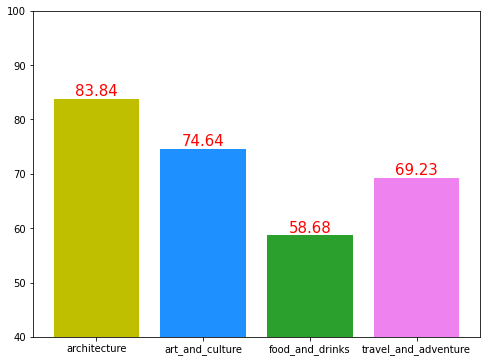

In [48]:
# 각 이미지의 적중률
plt.figure(figsize=(8,6))
x = target_names
fashon_type = target_names
values = score_list
colors = ['y', 'dodgerblue', 'C2', 'violet', 'brown', 'indigo', 'aquamarine', 'orange', 'khaki', 'slategray']

plt.bar(x, values, color=colors)
plt.xticks(x, fashon_type)
plt.ylim([40, 100])

for i, v in enumerate(x):
    plt.text(v, values[i], values[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='red',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

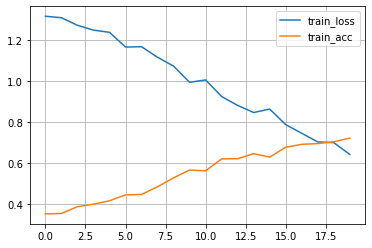

In [50]:
# 손실률, 정확도 시각화
plt.plot(cnn_history.history['loss'])
#plt.plot(loss)
plt.plot(cnn_history.history['accuracy'])
#plt.plot(acc)
plt.legend(['train_loss', 'train_acc'])
plt.grid()
plt.show()

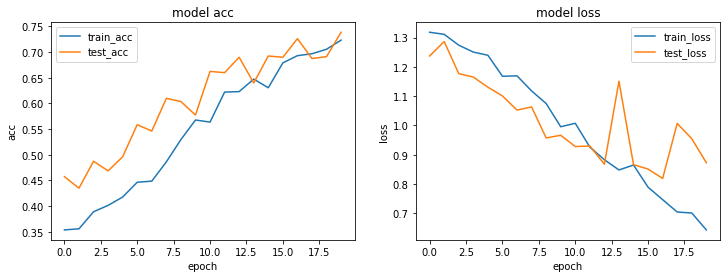

In [51]:
# cnn_history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) # 1행 2열의 도표, 1열
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])
plt.subplot(1, 2, 2) # 1행 2열의 도표, 2열
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])

## 전이학습

In [29]:
# Pre-trained 모델 가져오기
from tensorflow.keras.applications import ResNet50
cnn_base = ResNet50(include_top=False, weights='imagenet', 
                 input_shape=[data_height, data_width, channel_n],classes=4)  

In [30]:
model3 = Sequential()
### 특성추출 레이어를 쌓아준다.

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(data_height, data_width, channel_n)))
# model.add(MaxPool2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))

### 딥러닝 학습 레이어를 쌓아준다.
### 입력--히든--출력 순서대로 쌓아준다.
### 입력(1개)-- 1차원이여야함.

model3.add(cnn_base) 
model3.add(Flatten()) ## 이미지 데이터를 1차원으로 만들어주는 객체 
### 히든
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(rate=0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(rate=0.3))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(rate=0.3))
model3.add(Dense(12, activation='relu'))
model3.add(Dropout(rate=0.3))
model3.add(Dense(5, activation='relu'))
model3.add(Dropout(rate=0.3))

### 출력(1개)— 딥러닝하는 학습의 종류에 따라 다르게 써주어야 함.!!
### 이진 분류인 경우(1, sigmoid)
### 다중 분류인 경우(n, softmax)
### 회귀인 경우(1, linear)
model3.add(Dense(4, activation='softmax'))
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [31]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
es3=EarlyStopping(patience=10, restore_best_weights=True)
cp3=ModelCheckpoint('best_travel_cnn_ResNet50.h5')
cnn_history3=model3.fit(X_train, y_train, batch_size=50, epochs=50, validation_data=(X_test, y_test),
                      callbacks=[es3, cp3], verbose=2)

Epoch 1/50


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


64/64 - 432s - loss: 2.2105 - accuracy: 0.3013 - val_loss: 41.5464 - val_accuracy: 0.2637 - 432s/epoch - 7s/step
Epoch 2/50
64/64 - 417s - loss: 1.5281 - accuracy: 0.2866 - val_loss: 1.3863 - val_accuracy: 0.2463 - 417s/epoch - 7s/step
Epoch 3/50
64/64 - 400s - loss: 1.4883 - accuracy: 0.2897 - val_loss: 1.3863 - val_accuracy: 0.2463 - 400s/epoch - 6s/step
Epoch 4/50
64/64 - 405s - loss: 1.4121 - accuracy: 0.2856 - val_loss: 1.3863 - val_accuracy: 0.2463 - 405s/epoch - 6s/step
Epoch 5/50
64/64 - 408s - loss: 1.3980 - accuracy: 0.2788 - val_loss: 1.3863 - val_accuracy: 0.2463 - 408s/epoch - 6s/step
Epoch 6/50
64/64 - 432s - loss: 1.3912 - accuracy: 0.2841 - val_loss: 1.3984 - val_accuracy: 0.2562 - 432s/epoch - 7s/step
Epoch 7/50
64/64 - 417s - loss: 1.3893 - accuracy: 0.2834 - val_loss: 1.3999 - val_accuracy: 0.1250 - 417s/epoch - 7s/step
Epoch 8/50
64/64 - 446s - loss: 1.4051 - accuracy: 0.2766 - val_loss: 1.3839 - val_accuracy: 0.3088 - 446s/epoch - 7s/step
Epoch 9/50
64/64 - 416s - 

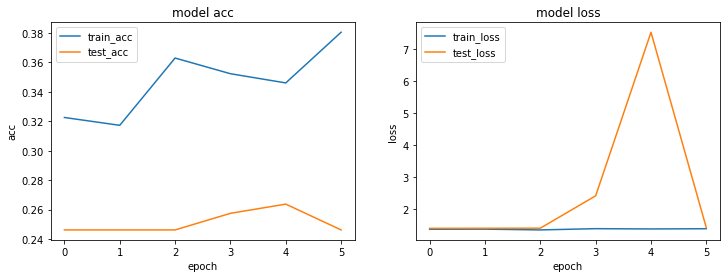

In [70]:
# cnn_history pationce=5
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) # 1행 2열의 도표, 1열
plt.plot(cnn_history3.history['accuracy'])
plt.plot(cnn_history3.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])
plt.subplot(1, 2, 2) # 1행 2열의 도표, 2열
plt.plot(cnn_history3.history['loss'])
plt.plot(cnn_history3.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])

## 전이학습 model3 pationce=10 시각화

In [48]:
test_result3=model3.evaluate(X_test, y_test)

25/25 [==============================] - 18s 696ms/step - loss: 13.4481 - accuracy: 0.4550


In [36]:
# 다중 분류에서는 predict를 할 때 각 항목이 될 가능성을 계산해준다.
y_pred3=model3.predict(X_test)

In [37]:
y_pred_test3=np.argmax(y_pred3, axis=-1)

In [38]:
print(confusion_matrix(y_pred_test3, y_test))

[[204  12  46 170]
 [  0  96  65   5]
 [  1  40  30   2]
 [  1  49  45  34]]


In [39]:
df3=pd.DataFrame(confusion_matrix(y_pred_test3, y_test))

In [41]:
# 각 travel image의 적중률 리스트
score_list3=[]
for i in range(4):
    score_list3.append(round((df3.iloc[i,i]/df3.sum(axis=1)[i])*100, 2))

In [42]:
score_list3

[47.22, 57.83, 41.1, 26.36]

In [43]:
target_names = ['architecture', 'art_and_culture', 'food_and_drinks', 'travel_and_adventure']

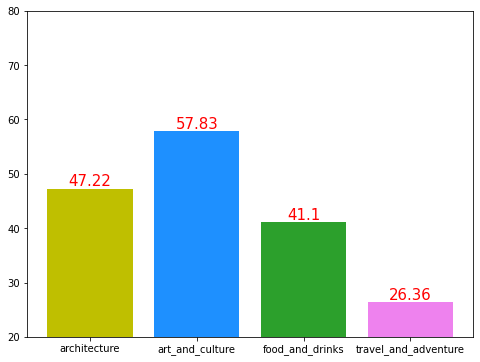

In [47]:
# 각 이미지의 적중률
plt.figure(figsize=(8,6))
x = target_names
fashon_type = target_names
values = score_list3
colors = ['y', 'dodgerblue', 'C2', 'violet', 'brown', 'indigo', 'aquamarine', 'orange', 'khaki', 'slategray']

plt.bar(x, values, color=colors)
plt.xticks(x, fashon_type)
plt.ylim([20, 80])

for i, v in enumerate(x):
    plt.text(v, values[i], values[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='red',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

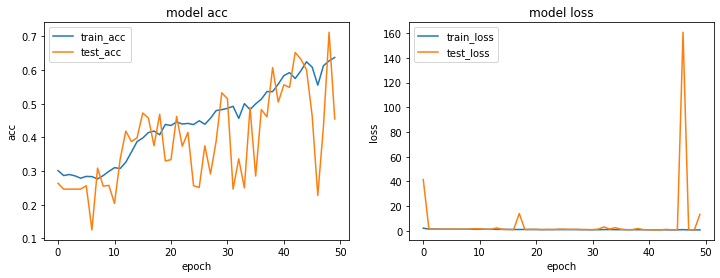

In [33]:
# cnn_history pationce=10
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) # 1행 2열의 도표, 1열
plt.plot(cnn_history3.history['accuracy'])
plt.plot(cnn_history3.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])
plt.subplot(1, 2, 2) # 1행 2열의 도표, 2열
plt.plot(cnn_history3.history['loss'])
plt.plot(cnn_history3.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])